In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.legacy.data import Field, BucketIterator, TabularDataset

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np
from tqdm.notebook import tqdm

import random
import math
import time

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
spacy_ru = spacy.load('ru_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

def tokenize_ru(text):
    """
    Tokenizes Russian text from a string into a list of strings
    """
    return [tok.text for tok in spacy_ru.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [4]:
SRC = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            include_lengths = False,
            batch_first=True)

TRG = Field(tokenize = tokenize_ru, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,
            batch_first=True)

In [5]:
path_to_data = "../data.txt"

In [6]:
dataset = TabularDataset(
    path=path_to_data,
    format='tsv',
    fields=[('src', SRC), ('trg', TRG)]
)

In [7]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [8]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [9]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     sort=False,
     device = device)

In [10]:
from transformer_with_sin_cos_pos_encoding import Encoder, Decoder, Seq2Seq

In [16]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 4
DEC_HEADS = 4
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [17]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [18]:
from my_utils import count_parameters

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 13,879,467 trainable parameters


In [22]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [23]:
model.apply(initialize_weights);

In [24]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [19]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [20]:
from my_utils import train_transformer, evaluate_transformer, epoch_time

In [29]:
for x in train_iterator:
    break

In [31]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
writer.add_graph(model, input_to_model=(x.src, x.trg[:,:-1]))
writer.close()

In [32]:
%load_ext tensorboard
%tensorboard --logdir runs

In [33]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train_transformer(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate_transformer(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), './models/transformer_sin_cos_encoding.pt')
    
    writer.add_scalar('mean train loss per epoch', train_loss, global_step=epoch)
    writer.add_scalar('mean val loss per epoch', valid_loss, global_step=epoch)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 30s
	Train Loss: 5.052 | Train PPL: 156.370
	 Val. Loss: 3.092 |  Val. PPL:  22.026
Epoch: 02 | Time: 0m 28s
	Train Loss: 2.911 | Train PPL:  18.371
	 Val. Loss: 2.454 |  Val. PPL:  11.638
Epoch: 03 | Time: 0m 28s
	Train Loss: 2.429 | Train PPL:  11.352
	 Val. Loss: 2.218 |  Val. PPL:   9.190
Epoch: 04 | Time: 0m 28s
	Train Loss: 2.153 | Train PPL:   8.612
	 Val. Loss: 2.081 |  Val. PPL:   8.013
Epoch: 05 | Time: 0m 28s
	Train Loss: 1.942 | Train PPL:   6.975
	 Val. Loss: 2.000 |  Val. PPL:   7.387
Epoch: 06 | Time: 0m 28s
	Train Loss: 1.757 | Train PPL:   5.794
	 Val. Loss: 1.898 |  Val. PPL:   6.672
Epoch: 07 | Time: 0m 28s
	Train Loss: 1.586 | Train PPL:   4.883
	 Val. Loss: 1.841 |  Val. PPL:   6.301
Epoch: 08 | Time: 0m 28s
	Train Loss: 1.438 | Train PPL:   4.212
	 Val. Loss: 1.808 |  Val. PPL:   6.098
Epoch: 09 | Time: 0m 28s
	Train Loss: 1.306 | Train PPL:   3.692
	 Val. Loss: 1.799 |  Val. PPL:   6.045
Epoch: 10 | Time: 0m 29s
	Train Loss: 1.187 | Train PPL

Val_loss падал все время обучения -> нет переобучения.

In [34]:
torch.cuda.empty_cache()

In [21]:
model.load_state_dict(torch.load('./models/transformer_sin_cos_encoding.pt'))

<All keys matched successfully>

In [23]:
num_batches = len(test_data.examples) // test_iterator.batch_size
start_time = time.time()
test_loss = evaluate_transformer(model, test_iterator, criterion)
elapsed_time = (time.time() - start_time) 
time_per_32_batch = elapsed_time / num_batches / 4

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} | Inference time if batch_size=32: {time_per_32_batch:.3f} sec')

| Test Loss: 2.000 | Test PPL:   7.388 | Inference time if batch_size=32: 0.007 sec


In [33]:
from my_utils import transformer_display_attention, transformer_translate_sentence

In [38]:
example_idx = 2

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {" ".join(src)}')
print(f'trg = {" ".join(trg)}')

src = some of the suites feature a spa bath .
trg = в некоторых люксах установлена гидромассажная ванна .


In [39]:
translation, attention = transformer_translate_sentence(src, SRC, TRG, model, device, max_len=100)

print(f'predicted trg = {" ".join(translation)}')

predicted trg = в некоторых люксах установлена гидромассажная ванна . <eos>


<ipython-input-37-8546ab0d7ba0>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-37-8546ab0d7ba0>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


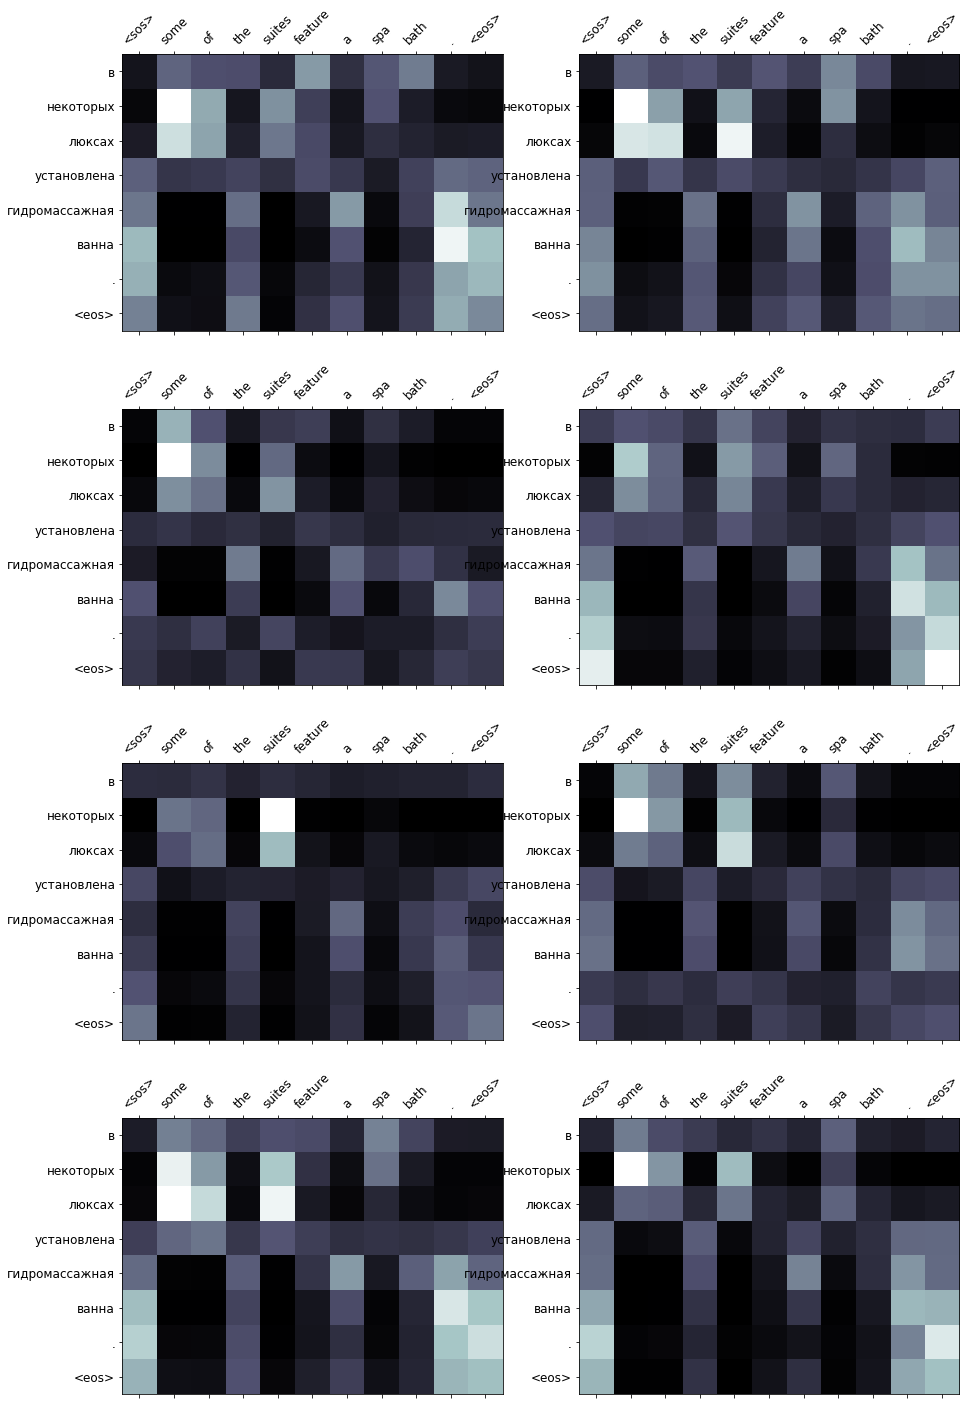

In [40]:
transformer_display_attention(src, translation, attention)

In [41]:
example_idx = 7

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {" ".join(src)}')
print(f'trg = {" ".join(trg)}')

src = breakfast is available as well .
trg = для гостей сервируется завтрак .


predicted trg = кроме того , в отеле работает ресторан . <eos>


<ipython-input-37-8546ab0d7ba0>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-37-8546ab0d7ba0>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


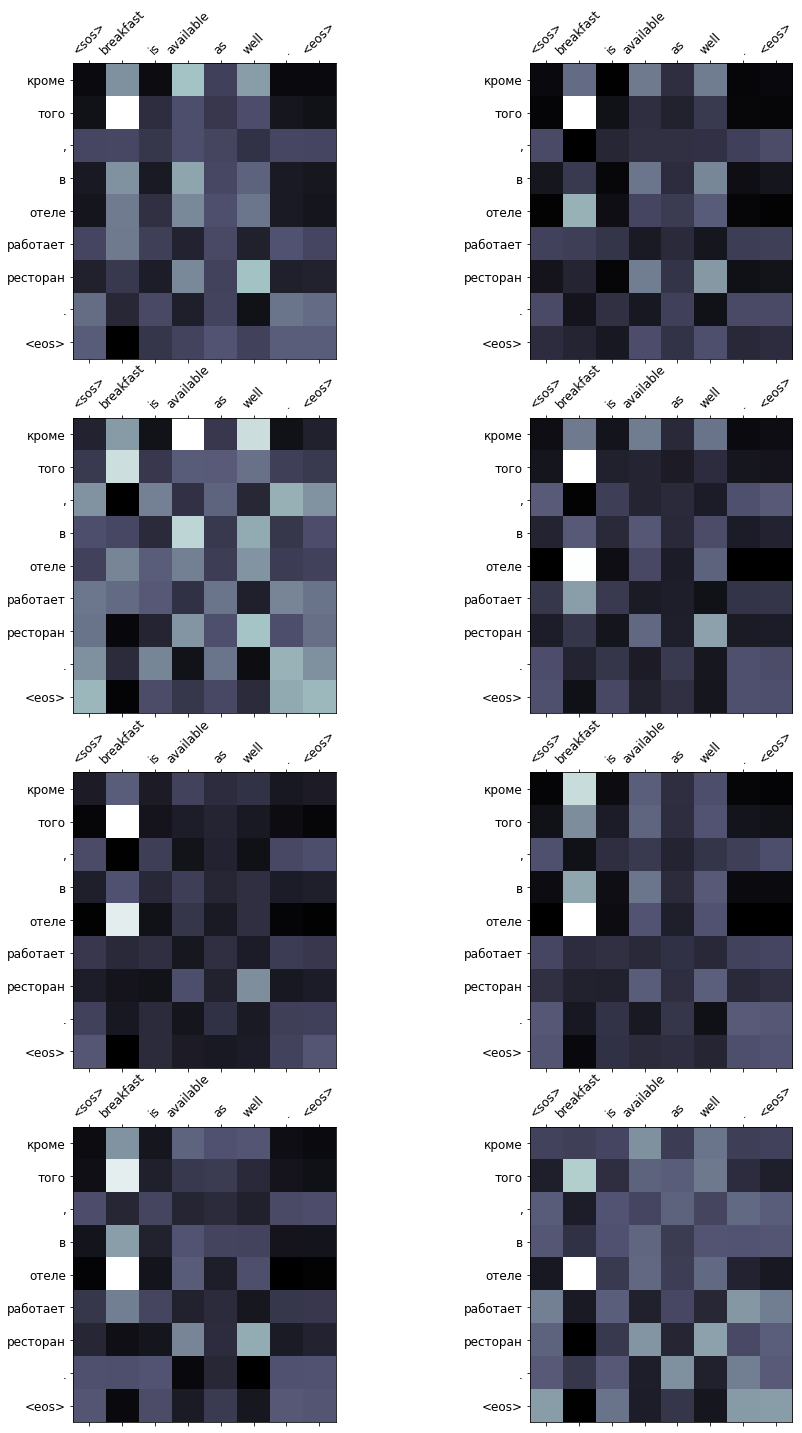

In [42]:
translation, attention = transformer_translate_sentence(src, SRC, TRG, model, device, max_len=100)

print(f'predicted trg = {" ".join(translation)}')

transformer_display_attention(src, translation, attention)

<ipython-input-37-8546ab0d7ba0>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-37-8546ab0d7ba0>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


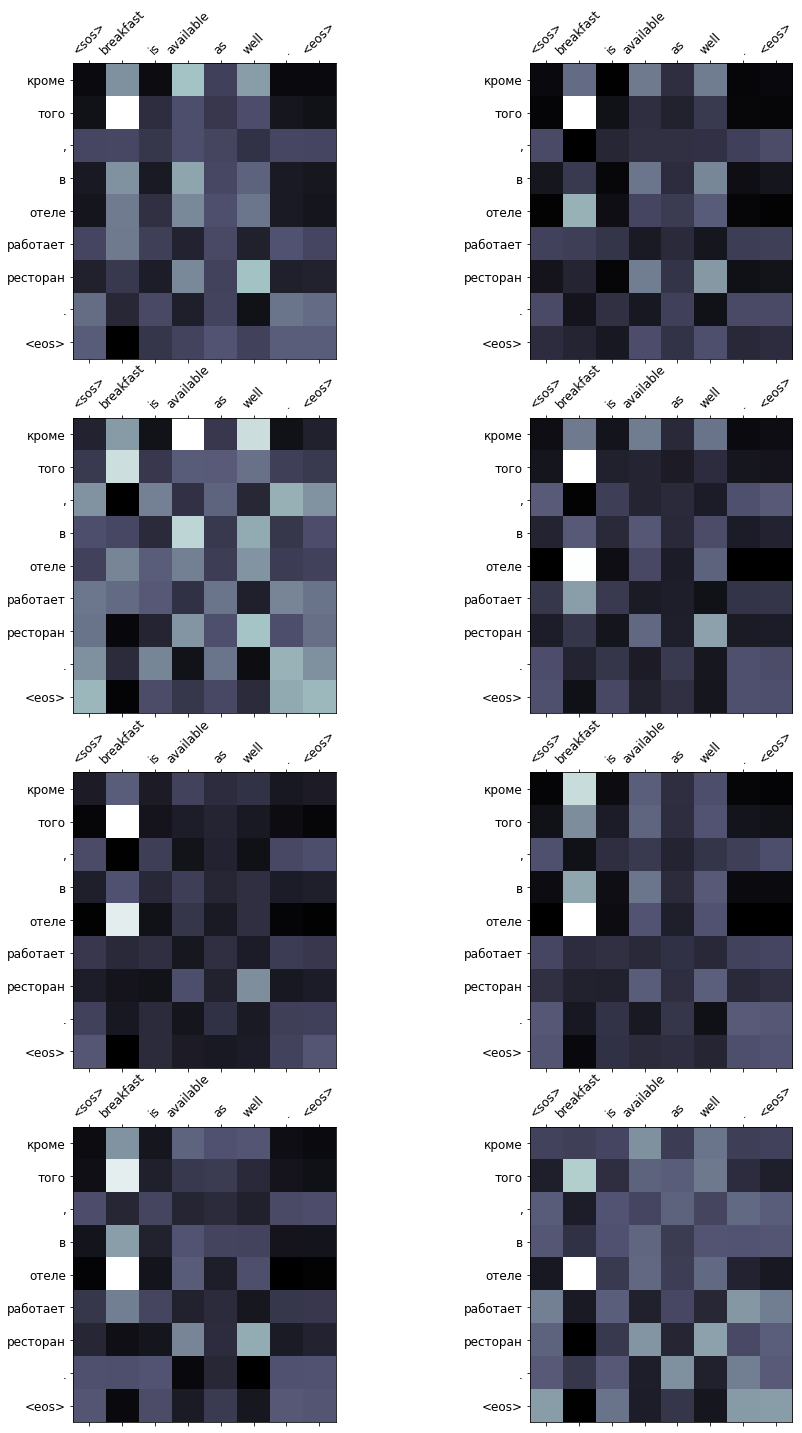

In [43]:
transformer_display_attention(src, translation, attention)

In [44]:
example_idx = 21

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {" ".join(src)}')
print(f'trg = {" ".join(trg)}')

src = it offers a sun terrace with an outdoor pool and a poolside bar .
trg = к услугам гостей солнечная терраса с открытым бассейном и баром у бассейна .


predicted trg = к услугам гостей открытый бассейн , терраса и бар . <eos>


<ipython-input-37-8546ab0d7ba0>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-37-8546ab0d7ba0>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


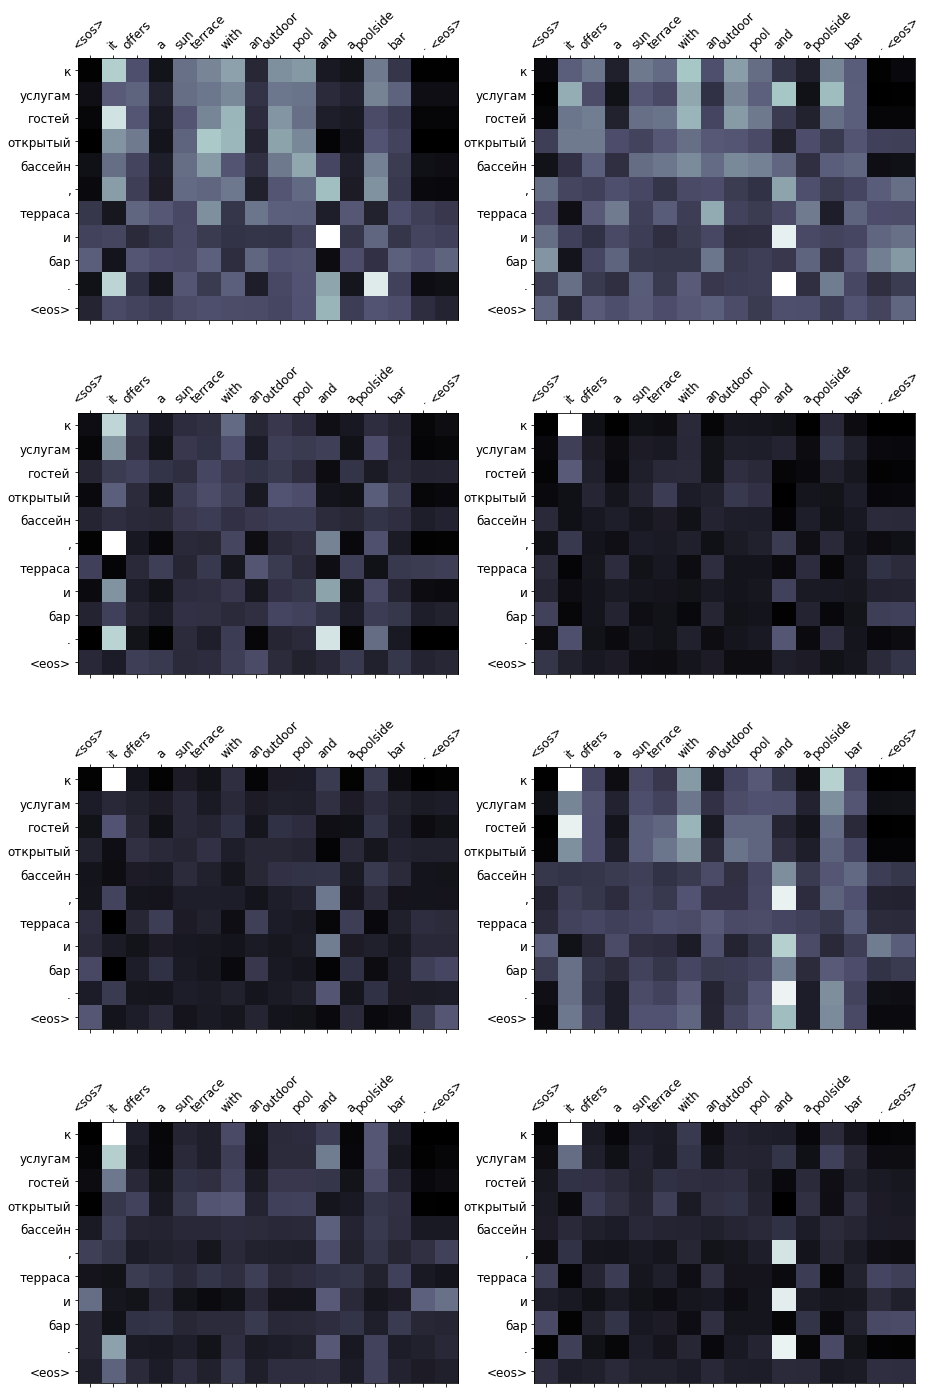

In [45]:
translation, attention = transformer_translate_sentence(src, SRC, TRG, model, device, max_len=100)

print(f'predicted trg = {" ".join(translation)}')

transformer_display_attention(src, translation, attention)

<ipython-input-37-8546ab0d7ba0>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-37-8546ab0d7ba0>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


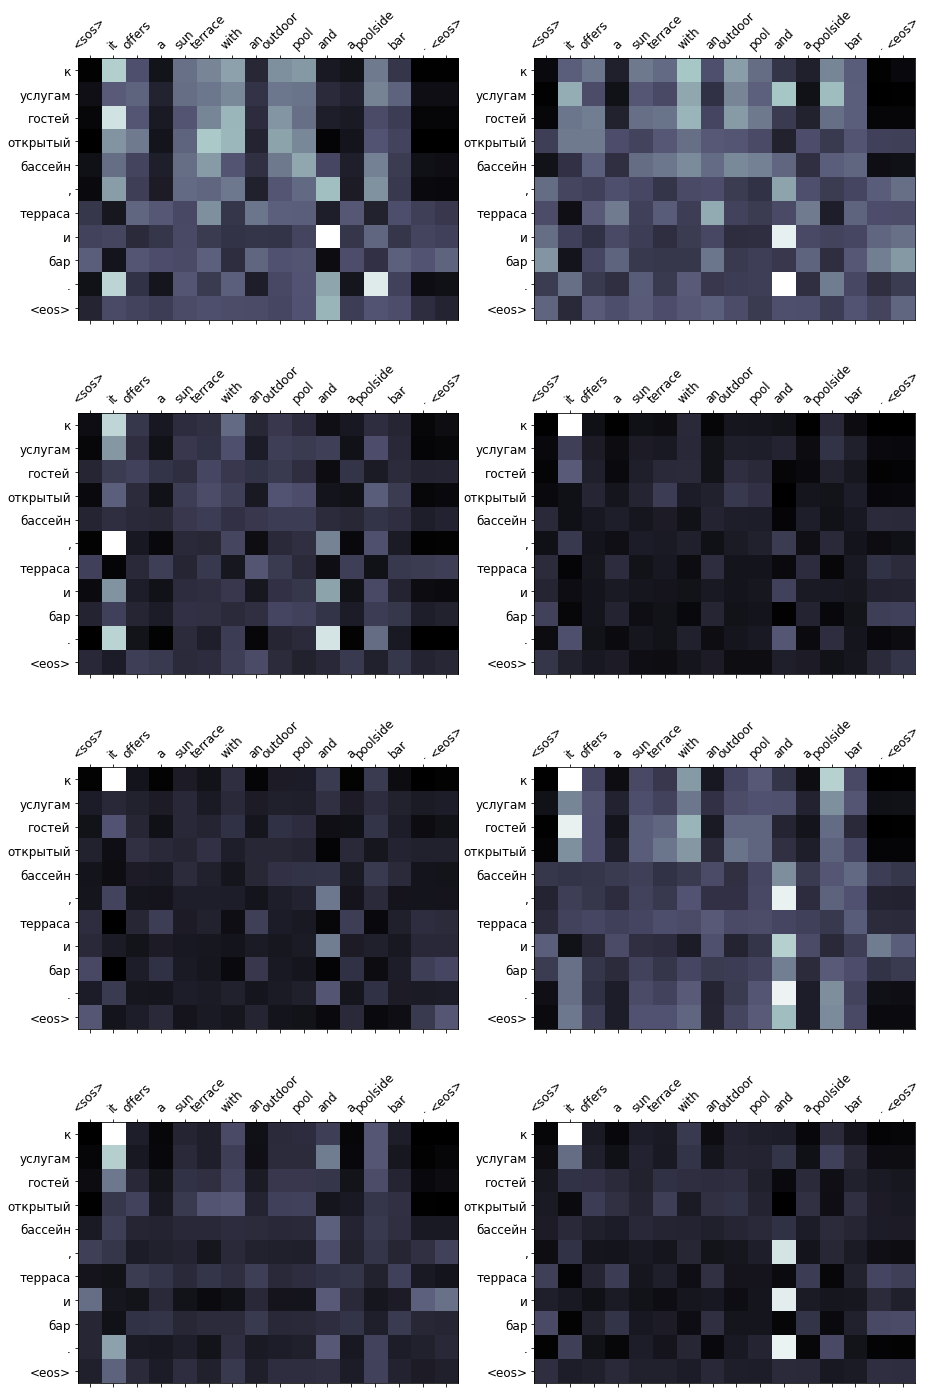

In [46]:
transformer_display_attention(src, translation, attention)

In [47]:
from my_utils import calculate_bleu

In [48]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device, max_len=100)

print(f'BLEU score = {bleu_score*100:.2f}')

  0%|          | 0/7500 [00:00<?, ?it/s]

BLEU score = 21.58
